# Optimization : Place the biggest possible house on a land

Constraints for the problem : 
- The house is a rectangle
- The land is any polygon, it can be convex or concave



The optimization is implemented with two different optimizers : PSO and DE

In the third section we will compare the two optimizers

In [1]:
from math import sqrt
import time
import pandas as pd

from sympy.geometry import Polygon as SympyPolygon
import matplotlib.pyplot as plt

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
from ipynb.fs.full.Rectangle import Rectangle
from ipynb.fs.full.Rectangle import create_animation, draw_polygons, draw_polygon, get_color
from ipynb.fs.full.Rectangle import erase_logs, LOGS

In [3]:
from ipynb.fs.full.OptimizerBuilder import OptimizerBuilder

# Main

In [4]:
poly1 = [(0,0), (0,100), (100,100), (110, 50), (100, 0)]
poly2 = [(0,0), (0,100), (50,90), (30,40), (71,25), (71,100), (100,100), (100,0)]
poly3 = [(0,0), (0,100), (30,90), (40,40), (71,25), (71,100), (100,100), (100,0)]
poly4 = [[10,10],[10,400],[400,400],[400,10]]
poly5 = [[10,10],[10,300],[250,300],[350,130],[200,10]] 
poly6 = [[50,150],[200,50],[350,150],[350,300],[250,300],[200,250],[150,350],[100,250],[100,200]]
poly7 = [[50,50],[50,400],[220,310],[220,170],[330,170],[330,480],[450,480],[450,50]]
POLY_LIST = [poly1, poly2, poly3, poly4, poly5, poly6, poly7]

[]

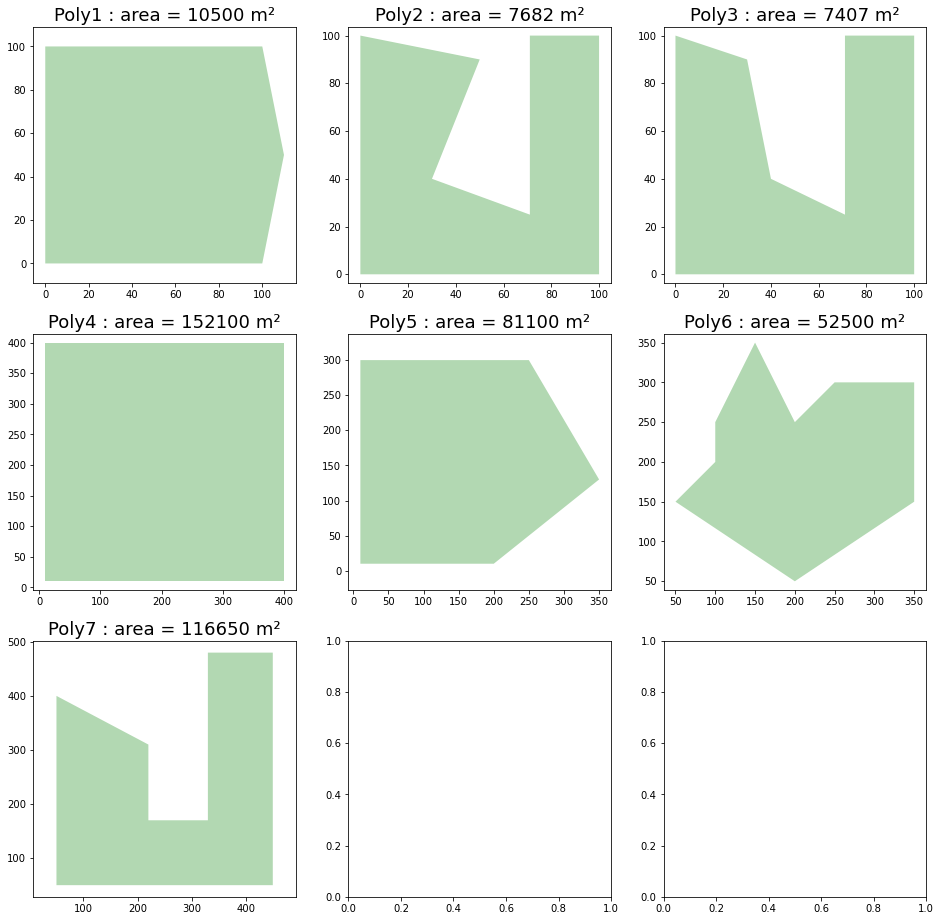

In [5]:
n_poly = len(POLY_LIST)
m = int(sqrt(n_poly)) + 1
fig, ax = plt.subplots(m, m, figsize=(16,16))
for i in range(n_poly):
    LAND = POLY_LIST[i]
    ax = plt.subplot(m, m, i+1)
    ax.set_title(f"Poly{i+1} : area = {int(abs(SympyPolygon(*LAND).area))} m²", fontsize=18)
    draw_polygon(LAND, color=get_color("Land"))
plt.plot()

## Hyperparameters

In [6]:
# Common parameters
DIM = 5
NB_PARTICLES = 60
NB_CYCLES = 800
LAND = poly1

# PSO specific
PSI, CMAX = 0.17, 1.47
# DE specific
CR, F = 0.9, 0.8

# Common operating parameters
# for the evaluation function
ACCEPT_WHEN_INVALID_MOVE = False
# for the logs and historization of data
LOG_PADDING = 50
SHOW_LOGS = False

In [7]:
BUILDER = OptimizerBuilder(LAND,
                           accept_when_invalid_move = ACCEPT_WHEN_INVALID_MOVE,
                           dim=DIM, 
                           n_agents=NB_PARTICLES, 
                           n_cycles=NB_CYCLES,
                           log_padding=LOG_PADDING,
                           isbetter_func=lambda f1, f2: f1 > f2,
                           show_logs=SHOW_LOGS)

## Particule Swarm Optimization

In [8]:
pso_optimizer = BUILDER.build_PSO(PSI=PSI, CMAX=CMAX)

### Visualization

In [9]:
erase_logs("PSO")
# pso_optimizer.fit()

{}

In [10]:
# create_animation(LOGS["PSO - Swarm"], LAND, "Swarm")

In [11]:
# create_animation(LOGS["PSO - Best"], LAND, "Best")

In [12]:
# printmd(f"### Best fitness = **{pso_optimizer.best_agent['bestfit']}**")

## Differential Evolution

In [13]:
de_optimizer = BUILDER.build_DE(CR=CR, F=F)

### Visualization

In [14]:
erase_logs("DE")
# de_optimizer.fit()

{}

In [15]:
# create_animation(LOGS["DE - Swarm"], LAND, "Swarm")

In [16]:
# printmd(f"### Best fitness = **{de_optimizer.best_agent['fit']}**")

le nombre d'itérations moyen requis pour l'atteinte de l'optimum global, le niveau d'optimisation moyen et finalement, le taux d'atteinte de l'optimum global.

## Optimizers comparison

To compare the optimizers fairly we should evaluate the following criterias
- **Average iteration number** required to reach the global optimum
- **Average optimization value**
- **Rate of reach** of the global optimum

**We will prefer the Wilcoxon test :**

A good statistic test that is easier to set up is the Wilcoxon test. By calculating the medians over several instances of the problem for the two optimizers we can deduce the difference between the two optimizers.

But this test ignores the time necessary to find the optimum and the number of iteration required. It is also unable to determine the most robust or the most precise of the two.

***

The comparison is based on the current state of the optimizers. Indeed, the results are intrinsically linked to the hyperparameters given to the optimizers.

**To be sure to compare them fairly we should first find the best hyperparameters for them**

We decided here to compare them without optimizing their hyperparameters. **So we suppose that the two optimizers are equivalent**

### Wilcoxon test

Extract the fitness over several instances of the problem

In [17]:
def run_n_times(optimizer, n_runs, optimizer_label="Opt?", show=False, land=LAND):
    if show:
        m = int(sqrt(n_runs - 1)) + 1
        fig, ax = plt.subplots(m, m, figsize=(16, 16))
        fig.suptitle(f"{optimizer_label} - {n_runs} runs comparison", fontsize=24)
    erase_logs(optimizer_label)
    times = []
    for i in range(n_runs):
        start_time = time.time()
        optimizer.fit()
        times.append(time.time() - start_time)
        if show:
            ax = plt.subplot(m, m, i+1)
            ax.set_title(f"Trial {i+1}: fit = {int(optimizer.best_agent['fit'])} m²", fontsize=18)
            draw_polygons([land, Rectangle(*optimizer.best_agent['pos']).to_rect()], colors=[get_color("Land"), get_color("Best final")])
    if show:
        plt.plot()
    return times

In [18]:
def get_medians(optimizer_label, optimizer_params, lands, n_runs, show=False):
    global BUILDER
    medians = []
    for land in lands:
        BUILDER.set_land(land)
        optimizer = BUILDER.build(optimizer_label, *optimizer_params)
        run_n_times(optimizer, n_runs, optimizer_label, show=show, land=land)
        runs_df = pd.DataFrame(LOGS[f"{optimizer_label} - Best final"])
        display(runs_df[['fitness', 'iteration']])
        median = runs_df[['fitness']].median()
        medians.append(median)
    return medians

In [19]:
pso_medians = get_medians(BUILDER.PSO_label, [PSI, CMAX], POLY_LIST[:3], 4, show=False)
de_medians = get_medians(BUILDER.DE_label, [CR, F], POLY_LIST[:3], 4, show=False)

100%|██████████| 800/800 [00:02<00:00, 328.82it/s]


,fitness,iteration
0,9988.953670,800
1,10103.456500,800
2,9480.976583,800
3,9399.805328,800


100%|██████████| 800/800 [00:02<00:00, 314.04it/s]


,fitness,iteration
0,1882.441923,800
1,2972.752566,800
2,2456.273805,800
3,2611.879512,800


100%|██████████| 800/800 [00:02<00:00, 349.36it/s]


,fitness,iteration
0,2848.683951,800
1,2846.287300,800
2,2207.730983,800
3,2832.363408,800


100%|██████████| 800/800 [00:01<00:00, 665.26it/s]


,fitness,iteration
0,10403.999985,800
1,10403.999827,800
2,10403.999922,800
3,10403.999994,800


100%|██████████| 800/800 [00:01<00:00, 620.46it/s]


,fitness,iteration
0,3059.999993,800
1,3071.999981,800
2,3071.999999,800
3,3071.999993,800


100%|██████████| 800/800 [00:01<00:00, 624.22it/s]


,fitness,iteration
0,2943.999961,800
1,2943.999990,800
2,2943.999990,800
3,2943.999976,800


100%|██████████| 800/800 [00:01<00:00, 642.28it/s]


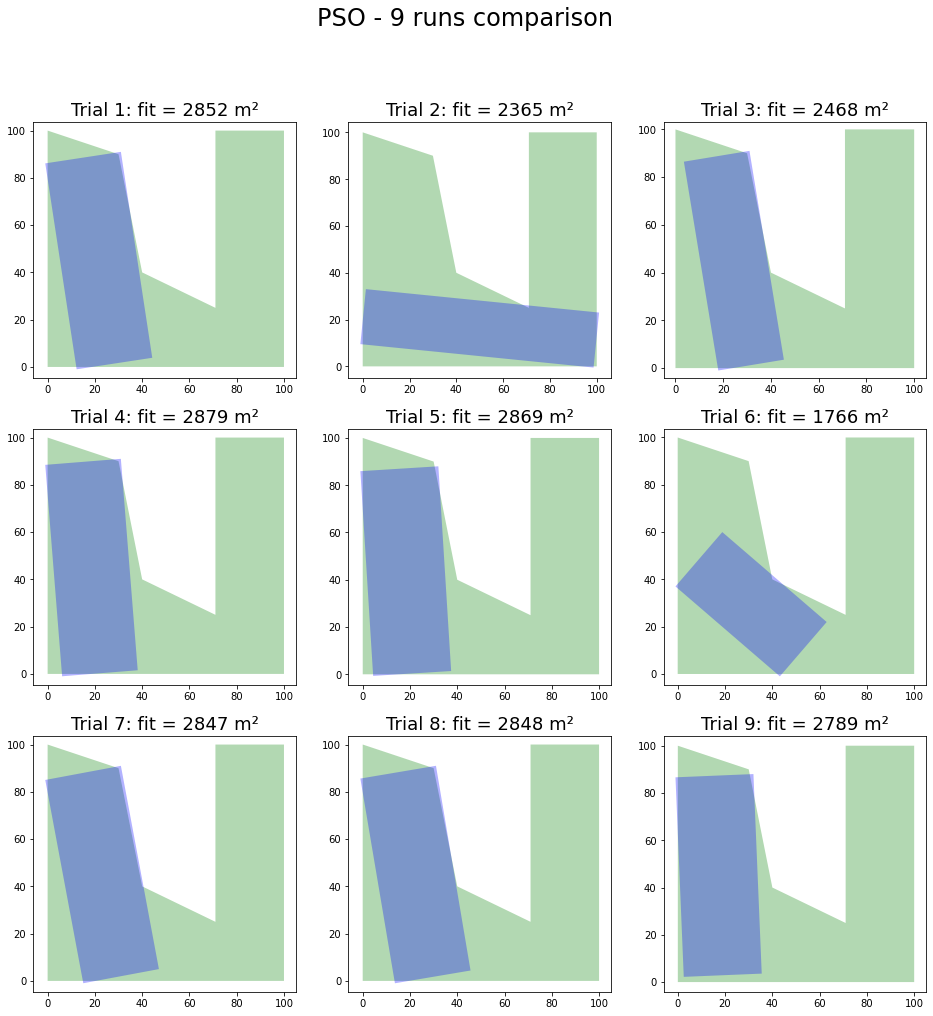

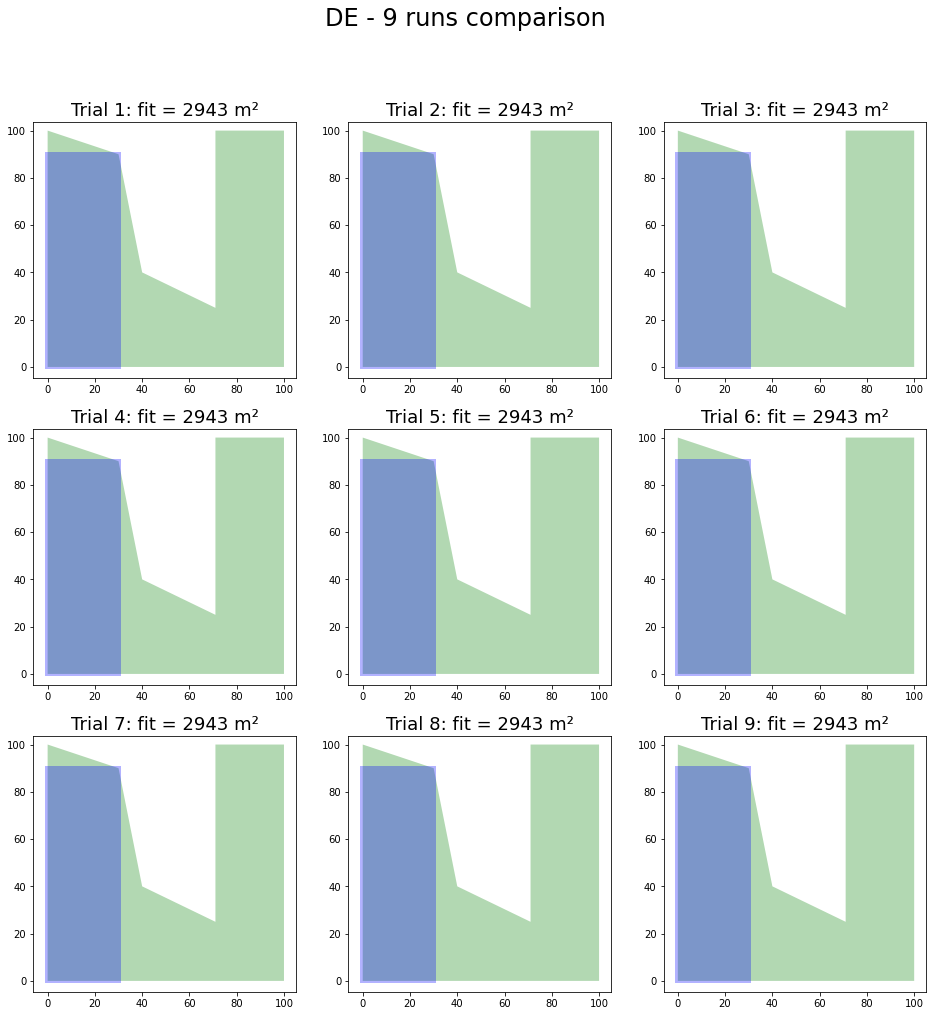

In [26]:
N_RUNS = 9
pso_times = run_n_times(pso_optimizer, N_RUNS, "PSO", show=True, land=poly3)
de_times = run_n_times(de_optimizer, N_RUNS, "DE", show=True, land=poly3)

In [21]:
pso_runs = pd.DataFrame(LOGS["PSO - Best final"])
pso_runs['time'] = pso_times
pso_runs

,polygons,title,iteration,fitness,time
0,"[[31.944143303671762, -0.9965942614857977, 31....",Itération 800 : PSO - Best final = 2931,800,2931.142092,2.617020
1,"[[-0.9686522684058364, 85.05953932169592, 15.0...",Itération 800 : PSO - Best final = 2846,800,2846.205581,2.479259
2,"[[-0.9994174611884101, -0.7440014123706025, 10...",Itération 800 : PSO - Best final = 2727,800,2727.645931,2.694723
3,"[[34.999999999999766, 71.62069138543845, -0.99...",Itération 800 : PSO - Best final = 2614,800,2614.288234,2.661049


In [22]:
de_runs = pd.DataFrame(LOGS["DE - Best final"])
de_runs['time'] = de_times
de_runs

,polygons,title,iteration,fitness,time
0,"[[-0.9999999974066587, 90.99999976929836, -0.9...",Itération 800 : DE - Best final = 2943,800,2943.999991,1.164019
1,"[[-0.9999997782461315, 90.99999979701667, -0.9...",Itération 800 : DE - Best final = 2943,800,2943.999952,1.162628
2,"[[30.99999990376487, -0.9999998808052238, 30.9...",Itération 800 : DE - Best final = 2943,800,2943.999973,1.196738
3,"[[31.000000010899075, -0.9999999677552076, 30....",Itération 800 : DE - Best final = 2943,800,2943.999994,1.178507


In [23]:
de_runs[['fitness']].median()

fitness    2943.999982
dtype: float64